# Fault Detection with VAR Models

### Plot the dataset

In [51]:
# Importing packages and libraries
from pandas import read_csv
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [52]:
def plot_multiple_series(actual, pred, attr):
    
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(actual.iloc[:,i], label="actual")
        plt.plot(pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return



In [53]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)



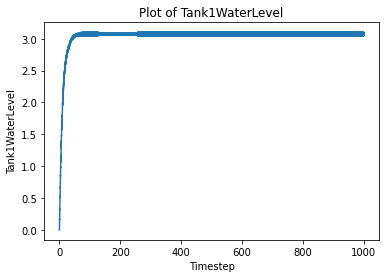

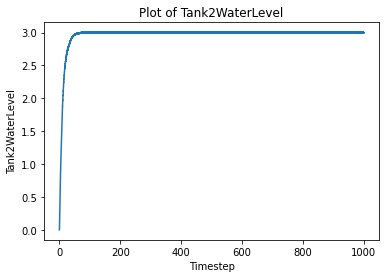

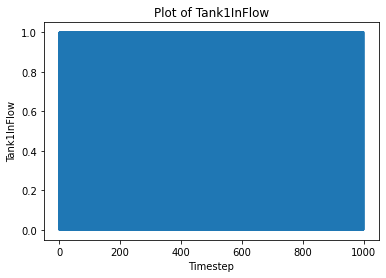

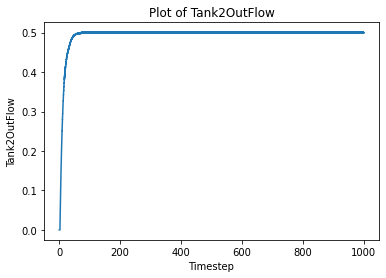

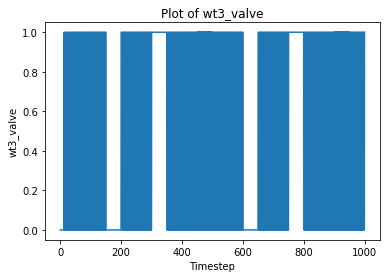

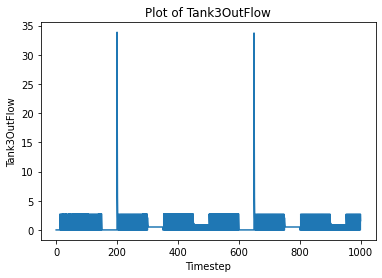

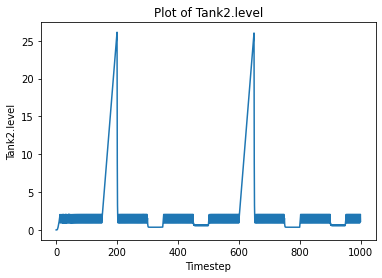

In [54]:
def plot_series(series, attr):
    for i in range(len(attr)):
        title = "Plot of "+str(attr[i])
        actual = series.iloc[:,i]
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel(attr[i])
        plt.plot(actual)
        plt.show()
        
file = 'test_series.csv'
df_raw = read_csv(file, header=0, index_col=0)
attr = list(pd.read_csv(file).columns.values)[1:]        
series = df_raw.iloc[:40000,:]
plot_series(series, attr)

### Normalisation of the golden dataset
##### This is to obtain the mean and standard deviation that would be used for normalising all the datasets

In [55]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)



normalised_data = normalise_timeseries(df_raw)

In [56]:
testData = normalised_data
testData

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  \
time                                                                   
0.00          -13.751169       -13.647795    -1.001251    -11.718138   
0.05          -13.751171       -13.647793    -1.001251    -11.718138   
0.10          -13.736104       -13.647793     0.998751    -11.718138   
0.15          -13.504895       -13.607095     0.998751    -11.718138   
0.20          -13.402350       -13.512143    -1.001251    -11.718138   
...                  ...              ...          ...           ...   
999.80          0.165423         0.123577     0.998751      0.126510   
999.85          0.239056         0.140814     0.998751      0.133595   
999.90          0.175745         0.174565    -1.001251      0.169767   
999.95          0.092379         0.167226    -1.001251      0.174569   
1000.00         0.068970         0.129598     0.998751      0.143823   

         wt3_valve  Tank3OutFlow  Tank2.level  
time                                           
0.00     -0.699801     -0.399607    -0.564448  
0.05     -0.699801     -0.399607    -0.564448  
0.10     -0.699801     -0.399607    -0.564448  
0.15     -0.699801     -0.399607    -0.564448  
0.20     -0.699801     -0.399607    -0.564448  
...            ...           ...          ...  
999.80    1.428978      1.245761    -0.249446  
999.85    1.428978      1.179017    -0.262224  
999.90    1.428978      1.085672    -0.280094  
999.95    1.428978      1.027728    -0.291188  
1000.00   1.428978      0.946702    -0.306700  

[20001 rows x 7 columns]

In [57]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = testData.iloc[:-nobs]
test = testData.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### Load the saved models

In [58]:
# The saved models are loaded to reconstruct the VAR
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
with open('var_golden_model.pkl', 'rb') as f:
    golden_model = pickle.load(f)

with open('var_ctrl_valueFlip.pkl', 'rb') as vf:
    valueFlip_model = pickle.load(vf)    

with open('var_ctrl_stuckat0.pkl', 'rb') as stuck0:
    stuckat0_model = pickle.load(stuck0)    

with open('var_ctrl_stuckat1.pkl', 'rb') as stuck1:
    stuckat1_model = pickle.load(stuck1)



In [59]:

# golden_model = VAR.load('var_golden_model.pkl')

# Retrieve the lag order
lag_order = golden_model.k_ar
# lag_order = 19

# Prepare new data
# newData = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
# newData = newData[attr]
# newData = newData[-lag_order:]
# newData = newData[:200,:]

# Initialise the VAR model
model_input = train.values
# model_input = newData.values
# golden_model.initialize_known(model_input)

# Make predictions
predictions = golden_model.forecast(model_input, steps=5)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=train.columns)

print(predictions_df)


   Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
0         0.167183         0.123733     0.983903      0.126655   1.044871   
1         0.272558         0.155106     0.946966      0.144638   0.709599   
2         0.174723         0.175185    -1.083198      0.170570   0.578172   
3         0.055069         0.156849    -1.065329      0.168955   0.495580   
4         0.069107         0.129627     0.992872      0.144064   0.392061   

   Tank3OutFlow  Tank2.level  
0      1.550677    -0.458067  
1      1.110043    -0.449423  
2      0.633508    -0.639071  
3      0.512458    -0.578725  
4      0.353579    -0.706053  


In [60]:
test

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  \
time                                                                   
850.05          0.165423         0.123577     0.998751      0.126510   
850.10          0.270704         0.154650     0.998751      0.144185   
850.15          0.175745         0.174565    -1.001251      0.169767   
850.20          0.057638         0.156503    -1.001251      0.168293   
850.25          0.068970         0.129598     0.998751      0.143823   
...                  ...              ...          ...           ...   
999.80          0.165423         0.123577     0.998751      0.126510   
999.85          0.239056         0.140814     0.998751      0.133595   
999.90          0.175745         0.174565    -1.001251      0.169767   
999.95          0.092379         0.167226    -1.001251      0.174569   
1000.00         0.068970         0.129598     0.998751      0.143823   

         wt3_valve  Tank3OutFlow  Tank2.level  
time                                           
850.05    1.428978      1.783620    -0.146474  
850.10    1.428978      1.641499    -0.173682  
850.15    1.428978      1.553208    -0.190586  
850.20    1.428978      1.429786    -0.214214  
850.25    1.428978      1.353086    -0.228899  
...            ...           ...          ...  
999.80    1.428978      1.245761    -0.249446  
999.85    1.428978      1.179017    -0.262224  
999.90    1.428978      1.085672    -0.280094  
999.95    1.428978      1.027728    -0.291188  
1000.00   1.428978      0.946702    -0.306700  

[3000 rows x 7 columns]

### Plot the input signals

In [61]:
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i], label="actual")
        plt.plot(x, pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return


In [62]:
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)

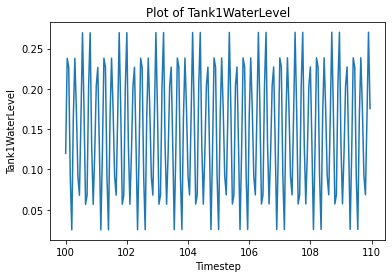

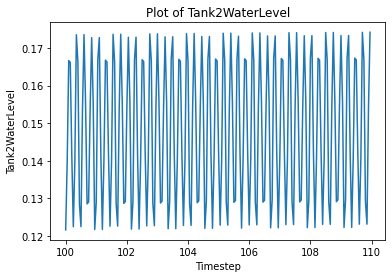

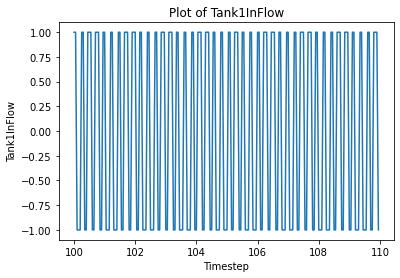

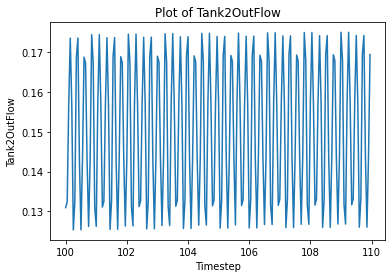

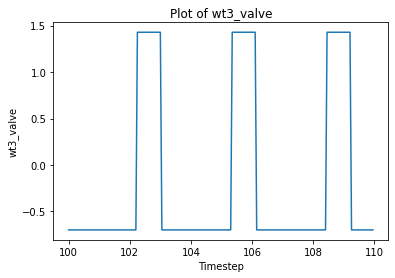

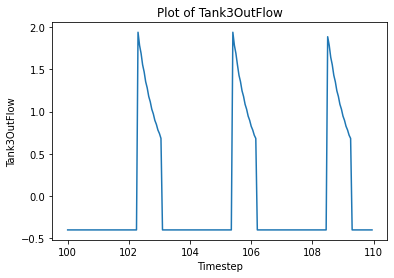

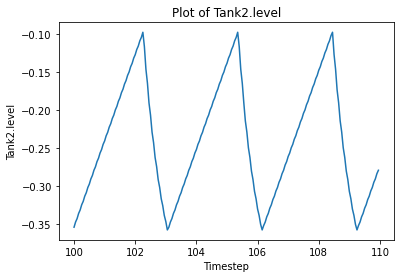

In [63]:
## SPecify the signal range of the golden data
begin = 2000
finish = 2200
input1 = testData.iloc[begin:finish,:]

## Visualise the input signals
plot_series(input1,attr)

# attr = list(pd.read_csv('test_series.csv').columns.values)[1:]
# for i in range(len(attr)):
#     title = "Input of {}".format(attr[i])
#     plt.title(title)
#     plt.xlabel("Timesteps")
#     plt.ylabel("Normalised values")
#     plt.plot(input1.iloc[:,i])
#     plt.show()

### Predict with the pretrained models (Golden data)
#### Golden model

In [64]:
steps = 15
predictions = golden_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=input1.columns)

print(predictions_df)

    Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
0          0.057220         0.156262    -1.001982      0.167961  -0.128005   
1          0.069045         0.129336     0.987115      0.143434  -0.410531   
2          0.204724         0.129601     0.979386      0.126737  -0.425361   
3          0.270468         0.154323     0.948861      0.143740  -0.306271   
4          0.131129         0.173704    -1.048894      0.175078  -0.169160   
5          0.056935         0.156449    -1.035140      0.167986  -0.191742   
6          0.120044         0.122567     0.990360      0.131813  -0.223554   
7          0.203688         0.130069     1.000554      0.127154  -0.264939   
8          0.227808         0.167862    -1.003368      0.157979  -0.308667   
9          0.131433         0.173835    -0.990126      0.175317  -0.355279   
10         0.025894         0.142704    -0.984286      0.157768  -0.395571   
11         0.121413         0.122972     1.007463      0.132379 

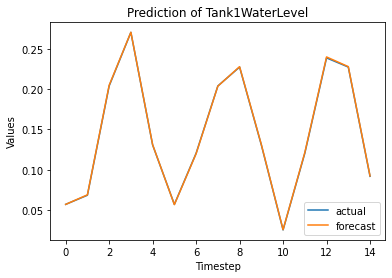

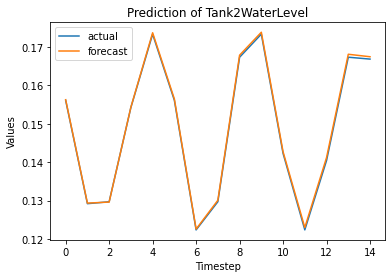

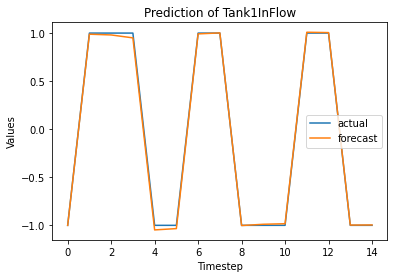

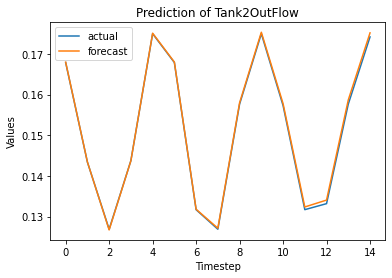

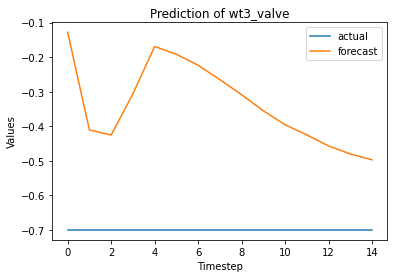

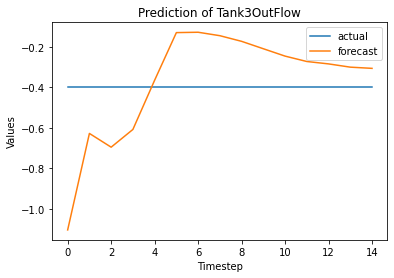

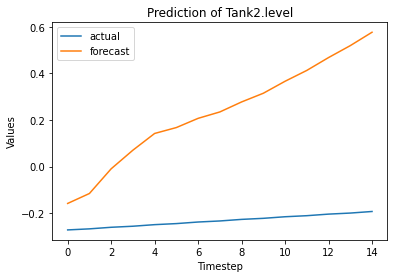

In [65]:
# plot_series(predictions_df, attr)
expected = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected, predictions_df, attr)
# plot_multiple_series(actual, pred, attr)

In [66]:
expected = expected.reset_index(drop=True)
RMSE_golden = []
for feat in attr:
    RMSE_golden.append(root_mse(predictions_df[feat], expected[feat]))
print(RMSE_golden)

[0.0005636045665987399, 0.0004597926600596921, 0.02165096894090062, 0.0005053180728826105, 0.38162900719262355, 0.26481287373245455, 0.5022646325855457]


#### ValueFlip

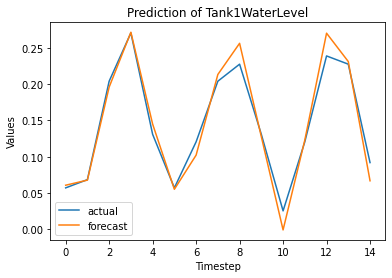

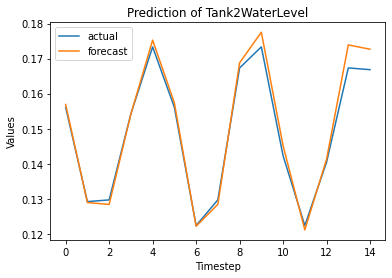

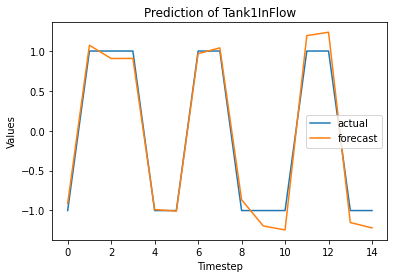

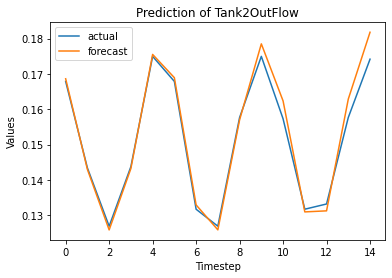

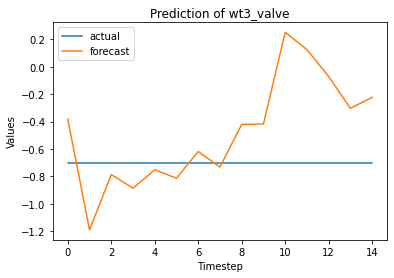

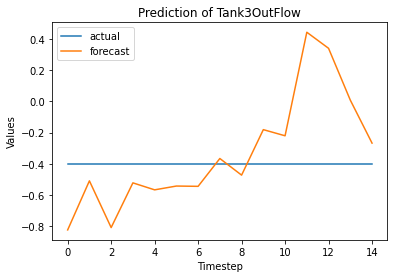

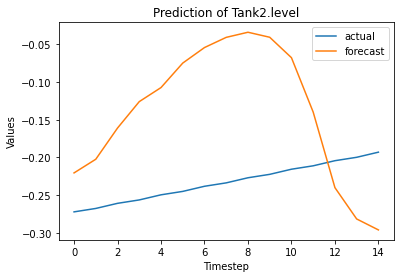

In [67]:
steps = 15
pred_valueFlip = valueFlip_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_valueFlip_df = pd.DataFrame(pred_valueFlip, columns=input1.columns)

# plot_series(predictions_df, attr)
expected_valueFlip = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_valueFlip, pred_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [68]:
expected_valueFlip = expected_valueFlip.reset_index(drop=True)
RMSE_vf = []
for feat in attr:
    RMSE_vf.append(root_mse(pred_valueFlip_df[feat], expected_valueFlip[feat]))
print(RMSE_vf)

[0.01601610565495033, 0.002788778756865522, 0.14385855582805632, 0.0029932688416987627, 0.44226851236136455, 0.3623143554636898, 0.13425541514428427]


### Stuck at zero

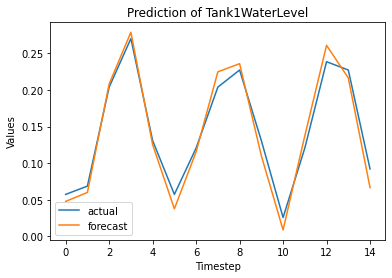

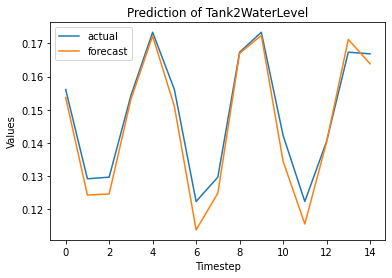

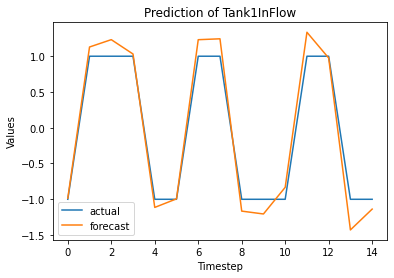

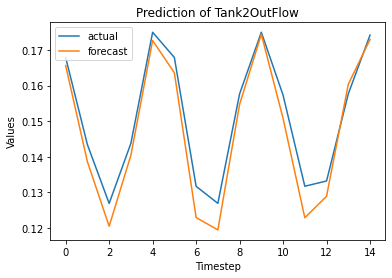

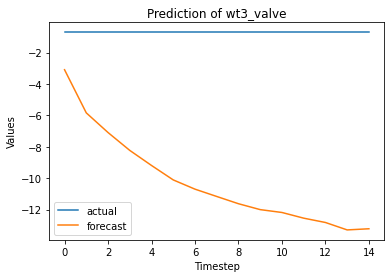

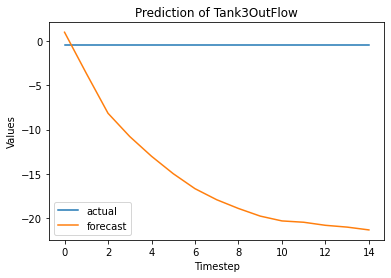

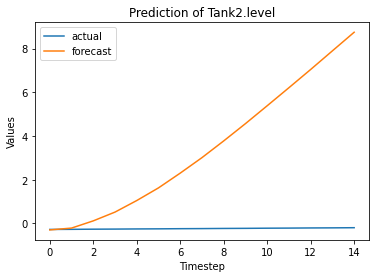

In [69]:
steps = 15
pred_stuckat0 = stuckat0_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_stuckat0_df = pd.DataFrame(pred_stuckat0, columns=input1.columns)

# plot_series(predictions_df, attr)
expected_stuckat0 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_stuckat0, pred_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [70]:
expected_stuckat0 = expected_stuckat0.reset_index(drop=True)
RMSE_s0 = []
for feat in attr:
    RMSE_s0.append(root_mse(pred_stuckat0_df[feat], expected_stuckat0[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSE_s0)

[0.015235306962757478, 0.004559930699817768, 0.20162331205105066, 0.0051234101917073055, 9.933892645136236, 16.182113757927112, 4.706470845404383]


### stuckat one

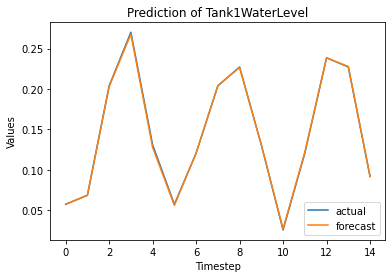

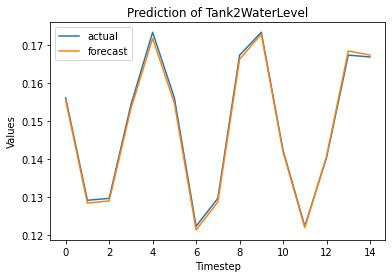

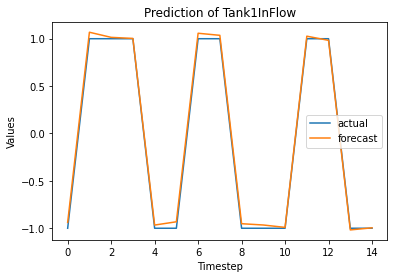

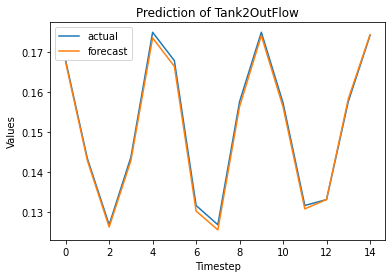

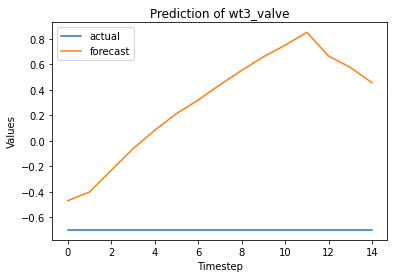

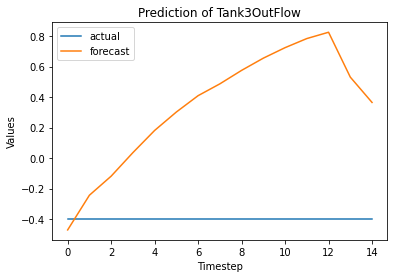

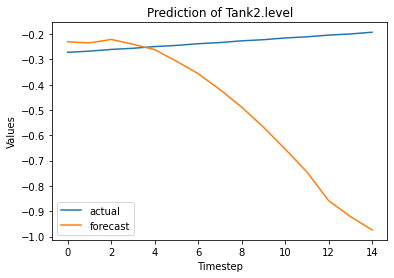

In [71]:
steps = 15
pred_stuckat1 = stuckat1_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_stuckat1_df = pd.DataFrame(pred_stuckat1, columns=input1.columns)
pred_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected_stuckat1 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_stuckat1, pred_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [72]:
# pred_stuckat1_df["Tank1WaterLevel"]
pred_stuckat1_df

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
time                                                                           
0            0.057519         0.155483    -0.939391      0.167439  -0.470425   
1            0.068361         0.128443     1.067086      0.142901  -0.401911   
2            0.203064         0.129016     1.013175      0.126346  -0.232177   
3            0.267918         0.153244     1.001698      0.142911  -0.062828   
4            0.127686         0.171727    -0.967642      0.173543   0.082876   
5            0.055962         0.154748    -0.932942      0.166445   0.213318   
6            0.120920         0.121394     1.056472      0.130330   0.320779   
7            0.204239         0.128739     1.034614      0.125613   0.439790   
8            0.226706         0.166254    -0.953391      0.156437   0.553264   
9            0.130738         0.172860    -0.966957      0.174135   0.660249   
10           0.026914         0.141915    -0.992125      0.156305   0.750506   
11           0.121851         0.122002     1.025546      0.130867   0.852887   
12           0.238449         0.140750     0.981548      0.133193   0.666148   
13           0.227896         0.168421    -1.018826      0.158316   0.576926   
14           0.091579         0.167352    -0.996735      0.174360   0.456474   

      Tank3OutFlow  Tank2.level  
time                             
0        -0.470377    -0.230901  
1        -0.243151    -0.235056  
2        -0.118276    -0.221467  
3         0.035817    -0.240385  
4         0.181175    -0.261667  
5         0.301942    -0.307396  
6         0.409039    -0.356331  
7         0.486381    -0.419344  
8         0.574671    -0.488545  
9         0.654726    -0.567397  
10        0.723465    -0.654010  
11        0.783078    -0.744284  
12        0.824452    -0.857864  
13        0.530521    -0.920494  
14        0.364659    -0.973538

In [73]:
expected_stuckat1 = expected_stuckat1.reset_index(drop=True)
RMSE_s1 = []
for feat in attr:
    RMSE_s1.append(root_mse(pred_stuckat1_df[feat], expected_stuckat1[feat]))

print(RMSE_s1)

[0.001233444576556476, 0.0008863209277770618, 0.04001658470524978, 0.0009455567953372353, 1.0745335799040159, 0.8260352962944557, 0.3895782523216812]


### Predict with the pretrained models (Stuckat0 faults data)
#### Golden model

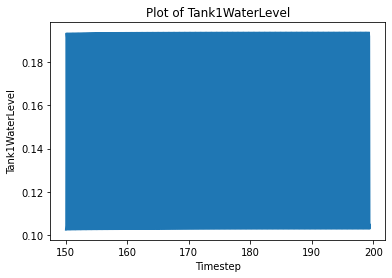

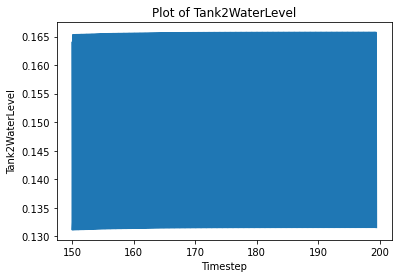

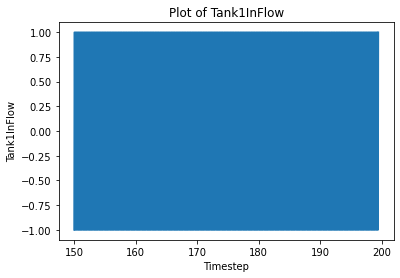

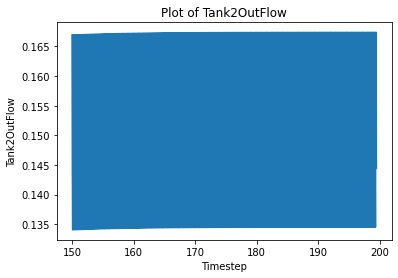

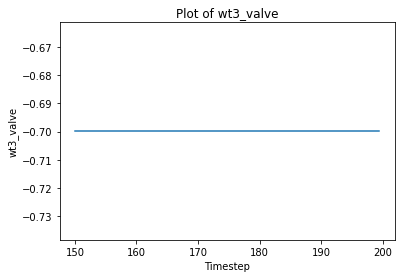

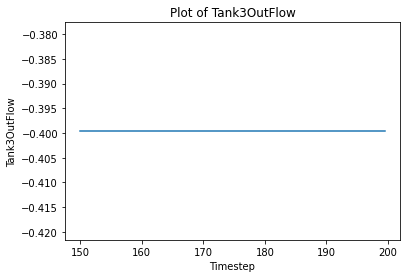

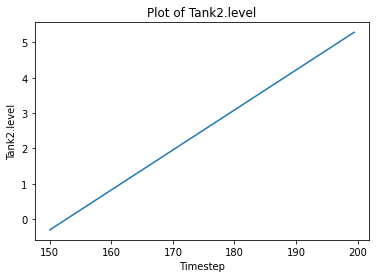

In [74]:
## SPecify the signal range
begin2 = 3000
finish2 = 3990
input2 = testData.iloc[begin2:finish2,:]

## Visualise the input signals
plot_series(input2,attr)

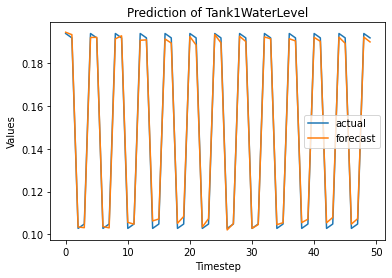

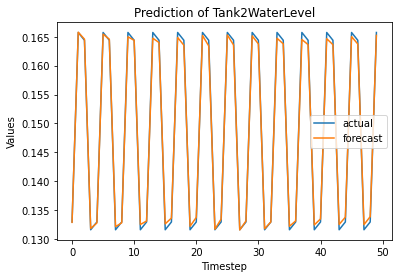

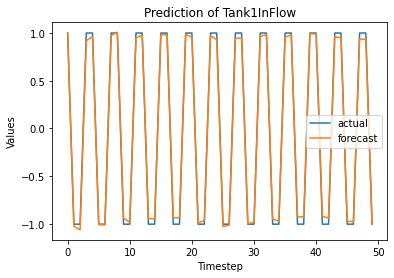

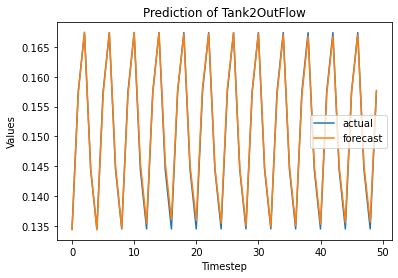

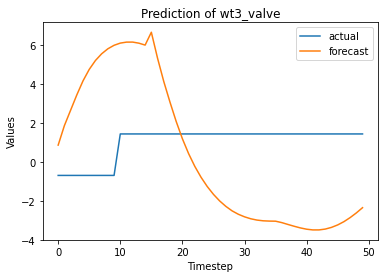

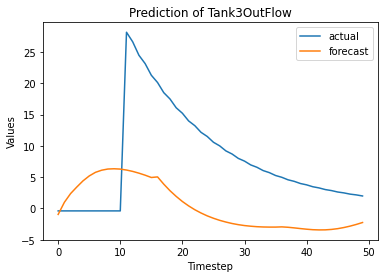

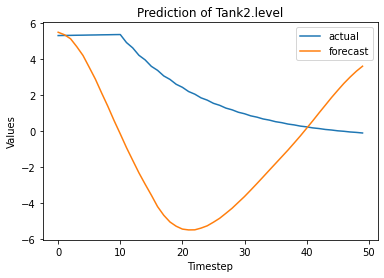

In [75]:
steps = 50
predictions2 = golden_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
predictions2_df = pd.DataFrame(predictions2, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2 = testData.iloc[finish2:finish2+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2, predictions2_df, attr)
# plot_multiple_series(actual, pred, attr)

In [76]:
expected2 = expected2.reset_index(drop=True)
RMSE2_golden = []
for feat in attr:
    RMSE2_golden.append(root_mse(predictions2_df[feat], expected2[feat]))
print(RMSE2_golden)

[0.0019714003177163917, 0.0006505964728011842, 0.044168731710610754, 0.0006090904462637851, 4.269240826551679, 10.634775463508442, 4.751100826416216]


#### ValueFlip

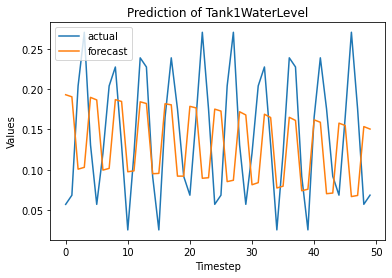

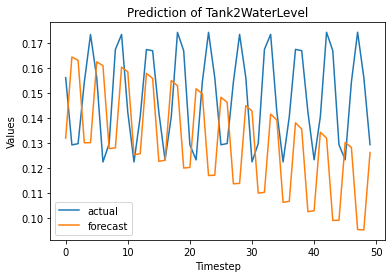

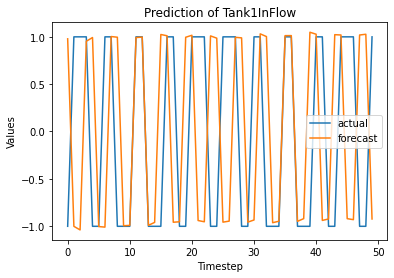

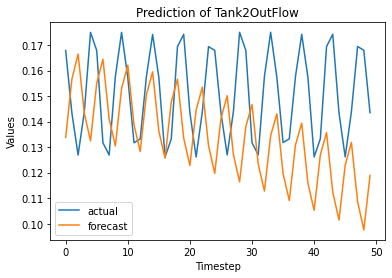

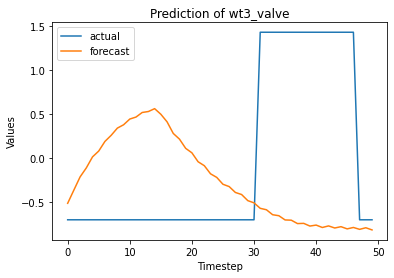

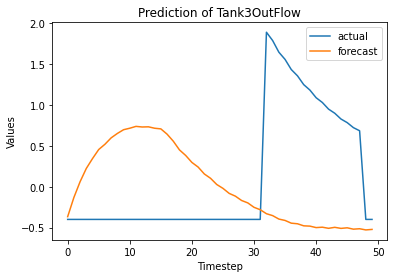

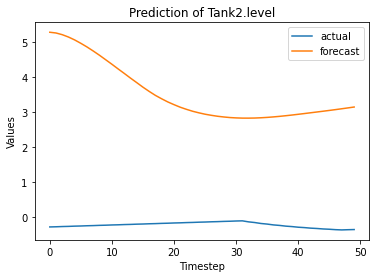

In [77]:
steps = 50
pred2_valueFlip = valueFlip_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_valueFlip_df = pd.DataFrame(pred2_valueFlip, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2_valueFlip = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_valueFlip, pred2_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [78]:
expected2_valueFlip = expected2_valueFlip.reset_index(drop=True)
RMSE2_vf = []
for feat in attr:
    RMSE2_vf.append(root_mse(pred2_valueFlip_df[feat], expected2_valueFlip[feat]))
print(RMSE2_vf)

[0.08992153851768295, 0.032452927732459336, 1.4297835189148795, 0.030046738545797317, 1.3780264431125637, 1.1343526784886258, 3.8461681421508565]


### Stuck at zero

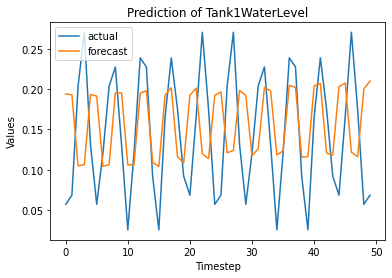

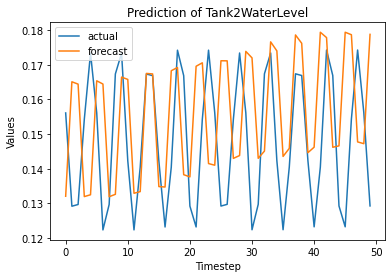

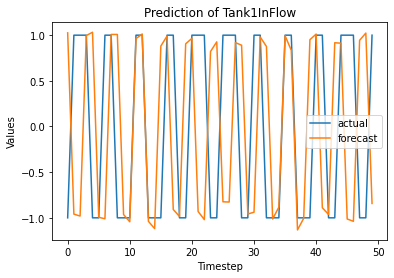

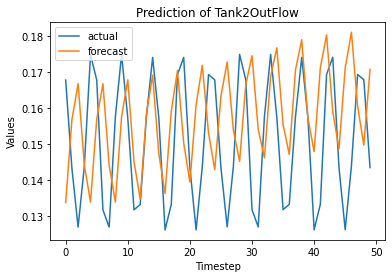

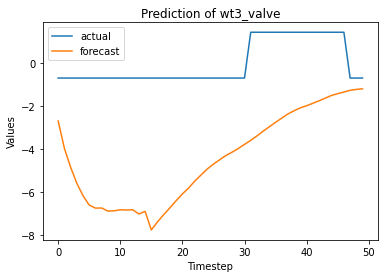

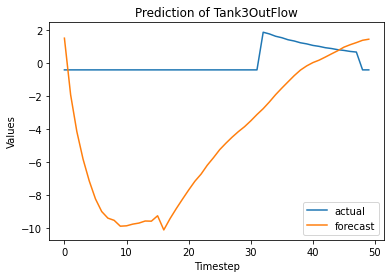

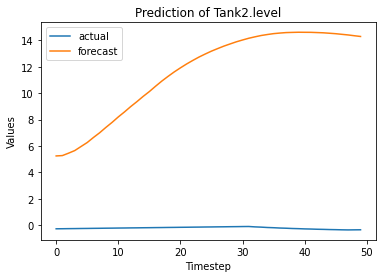

In [79]:
steps = 50
pred2_stuckat0 = stuckat0_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_stuckat0_df = pd.DataFrame(pred2_stuckat0, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2_stuckat0 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_stuckat0, pred2_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [80]:
expected2_stuckat0 = expected2_stuckat0.reset_index(drop=True)
RMSE2_s0 = []
for feat in attr:
    RMSE2_s0.append(root_mse(pred2_stuckat0_df[feat], expected2_stuckat0[feat]))

print(RMSE2_s0)

[0.08722075081565542, 0.026086075598875085, 1.3989454444537317, 0.02292571195937251, 4.660232597799785, 5.818796561924538, 12.273005918068858]


### stuckat one

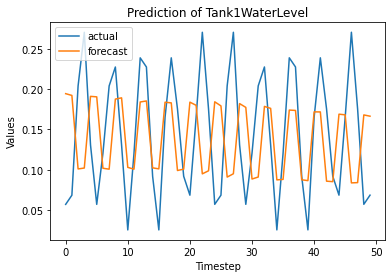

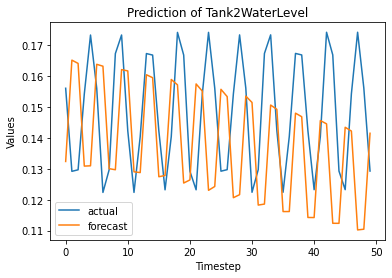

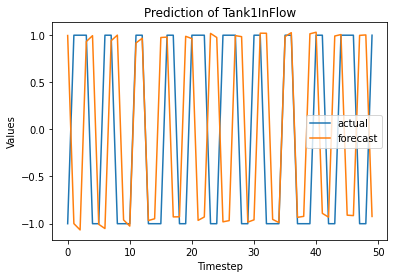

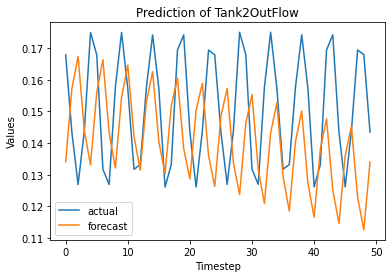

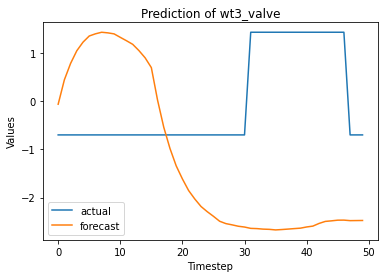

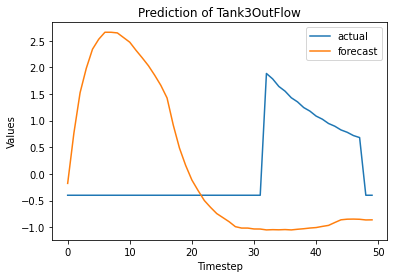

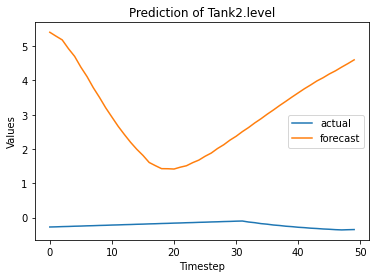

In [81]:
steps = 50
pred2_stuckat1 = stuckat1_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_stuckat1_df = pd.DataFrame(pred2_stuckat1, columns=input2.columns)
pred2_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected2_stuckat1 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_stuckat1, pred2_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [82]:
expected2_stuckat1 = expected2_stuckat1.reset_index(drop=True)
RMSE2_s1 = []
for feat in attr:
    RMSE2_s1.append(root_mse(pred2_stuckat1_df[feat], expected2_stuckat1[feat]))

print(RMSE2_s1)

[0.08909382883775206, 0.027952753733271378, 1.427513163184482, 0.025276887561043647, 2.64562878211193, 1.9412557733608518, 3.5010660737976154]


### Predict with the pretrained models (Stuckat1 fault data)
#### Golden model

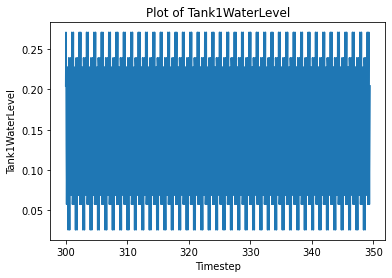

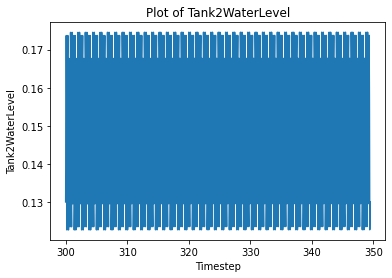

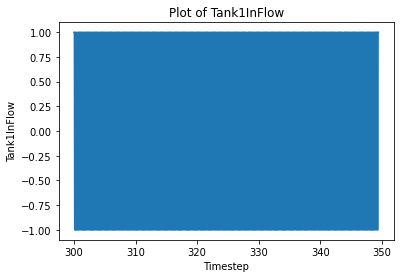

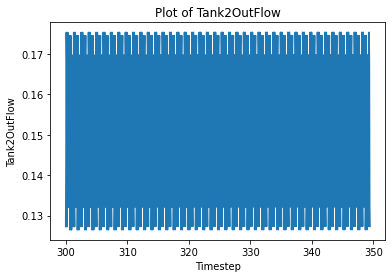

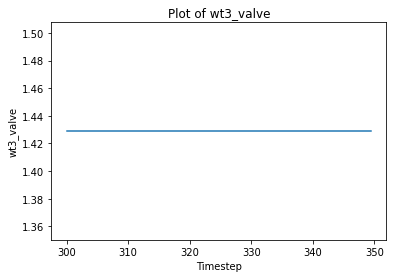

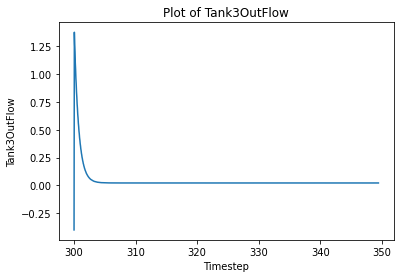

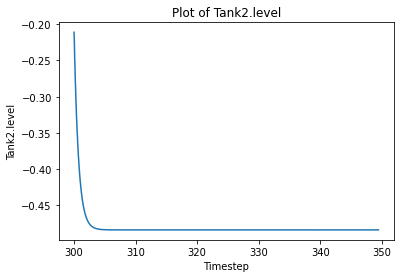

In [83]:
## SPecify the signal range
begin3 = 6000
finish3 = 6990
input3 = testData.iloc[begin3:finish3,:]

## Visualise the input signals
plot_series(input3,attr)

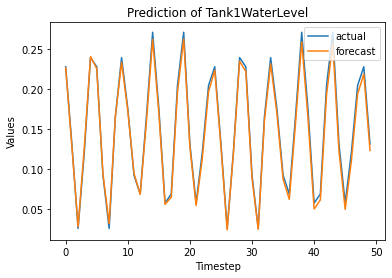

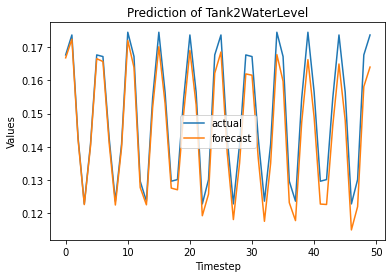

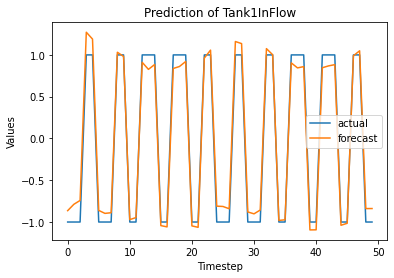

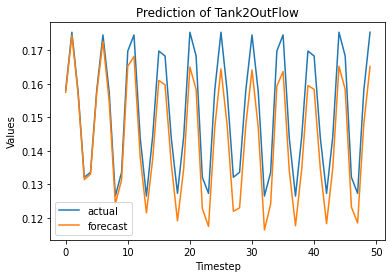

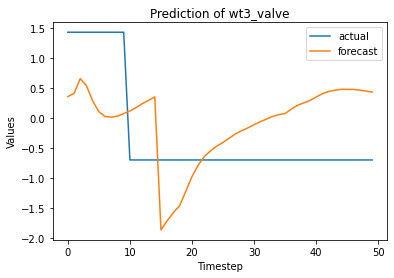

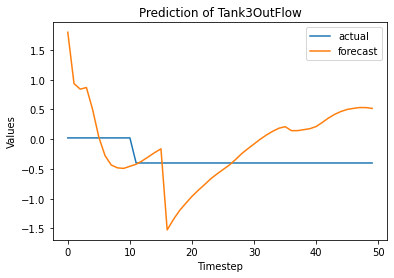

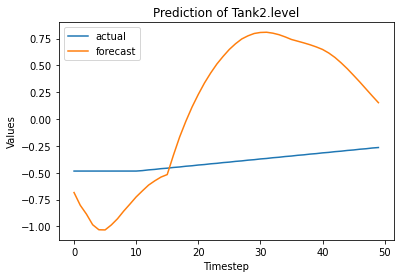

In [84]:
steps = 50
predictions3 = golden_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
predictions3_df = pd.DataFrame(predictions3, columns=input3.columns)

# plot_series(predictions_df, attr)
expected3 = testData.iloc[finish3:finish3+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3, predictions3_df, attr)
# plot_multiple_series(actual, pred, attr)

In [85]:
expected3 = expected3.reset_index(drop=True)
RMSE3_golden = []
for feat in attr:
    RMSE3_golden.append(root_mse(predictions3_df[feat], expected3[feat]))
print(RMSE3_golden)

[0.006620822133720061, 0.005417079542115896, 0.12478965927715019, 0.008430153138452103, 0.9312253592797806, 0.6432842772565059, 0.7732119769736885]


#### ValueFlip

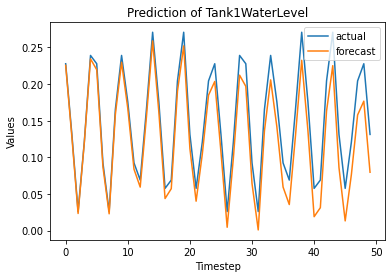

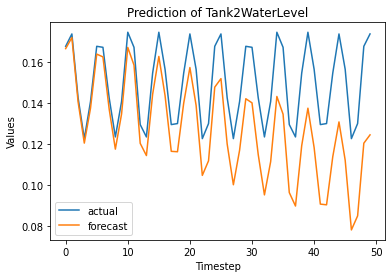

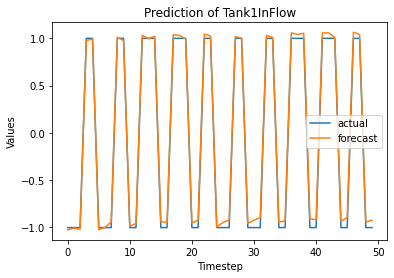

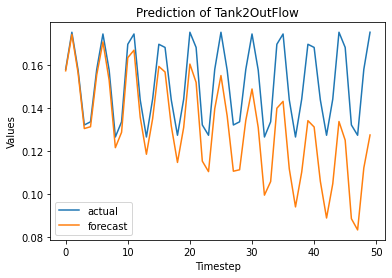

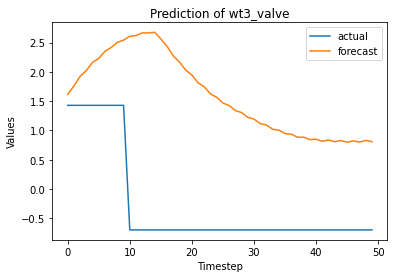

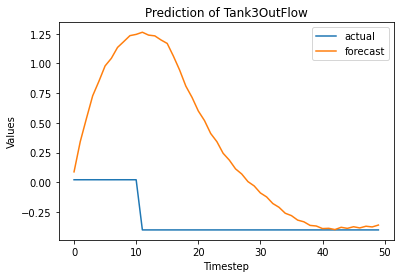

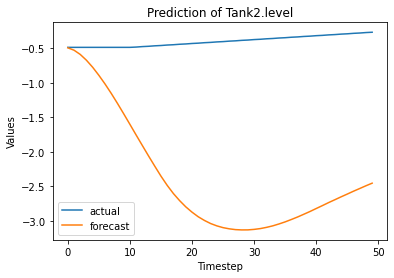

In [86]:
steps = 50
pred3_valueFlip = valueFlip_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
pred3_valueFlip_df = pd.DataFrame(pred3_valueFlip, columns=input3.columns)

# plot_series(predictions_df, attr)
expected3_valueFlip = testData.iloc[finish3:finish3 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3_valueFlip, pred3_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [87]:
expected3_valueFlip = expected3_valueFlip.reset_index(drop=True)
RMSE3_vf = []
for feat in attr:
    RMSE3_vf.append(root_mse(pred3_valueFlip_df[feat], expected3_valueFlip[feat]))
print(RMSE3_vf)

[0.027587176401309994, 0.026230492199695782, 0.05109981915212687, 0.025284456196252678, 2.049288776614389, 0.8214095899720977, 2.158348896876499]


### Stuck at zero

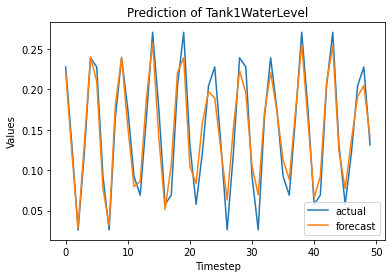

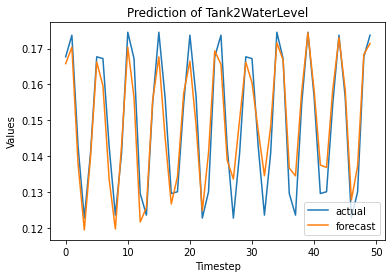

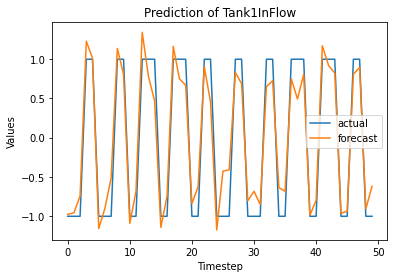

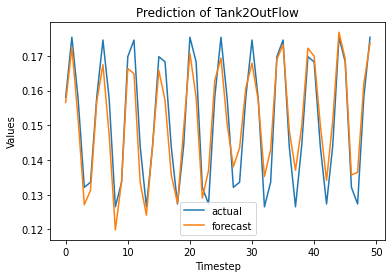

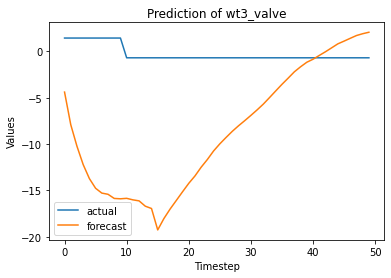

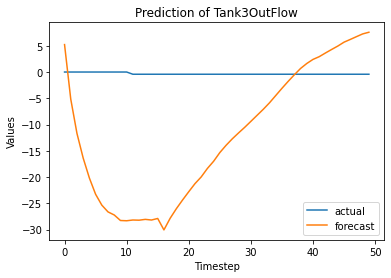

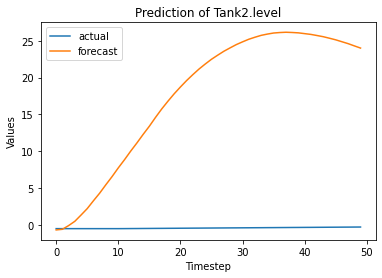

In [88]:
steps = 50
pred3_stuckat0 = stuckat0_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
pred3_stuckat0_df = pd.DataFrame(pred3_stuckat0, columns=input3.columns)

# plot_series(predictions_df, attr)
expected3_stuckat0 = testData.iloc[finish3:finish3 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3_stuckat0, pred3_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [89]:
expected3_stuckat0 = expected3_stuckat0.reset_index(drop=True)
RMSE3_s0 = []
for feat in attr:
    RMSE3_s0.append(root_mse(pred3_stuckat0_df[feat], expected3_stuckat0[feat]))

print(RMSE3_s0)

[0.020382263108240952, 0.005990197581986009, 0.27837362313513914, 0.006081988247581438, 10.839672769951253, 17.380308452791326, 20.16096282349285]


### stuckat one

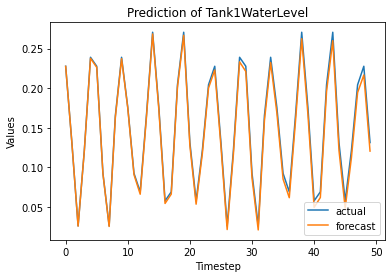

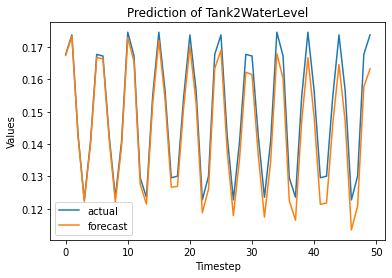

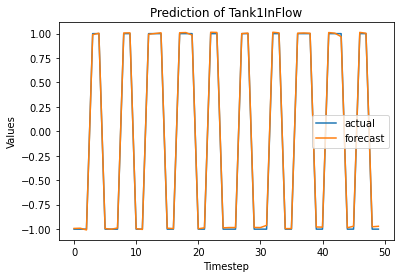

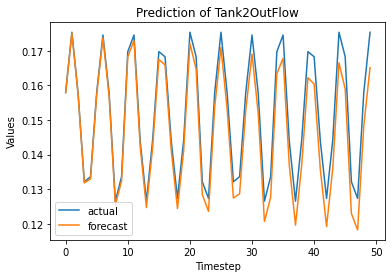

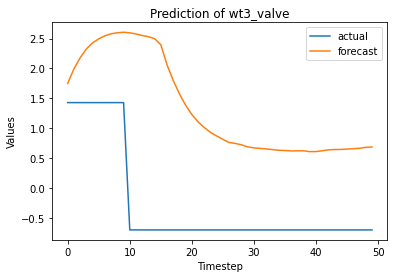

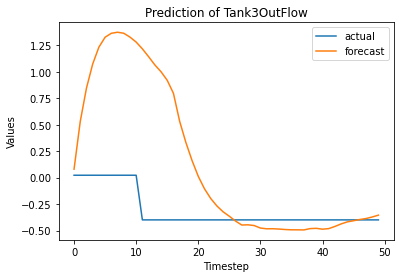

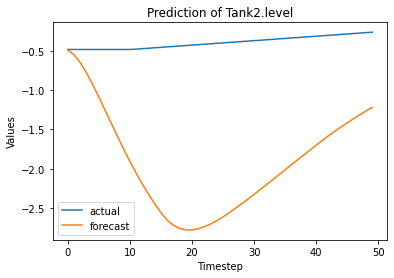

In [90]:
steps = 50
pred3_stuckat1 = stuckat1_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
pred3_stuckat1_df = pd.DataFrame(pred3_stuckat1, columns=input3.columns)
pred3_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected3_stuckat1 = testData.iloc[finish3:finish3 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3_stuckat1, pred3_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [91]:
expected3_stuckat1 = expected3_stuckat1.reset_index(drop=True)
RMSE3_s1 = []
for feat in attr:
    RMSE3_s1.append(root_mse(pred3_stuckat1_df[feat], expected3_stuckat1[feat]))

print(RMSE3_s1)

[0.005869227930931206, 0.005583547776217622, 0.014013269295899163, 0.005393223010150899, 1.7699172410505055, 0.7526823501946116, 1.6549200041270984]


### Predict with the pretrained models (ValueFlip fault data)
#### Golden model

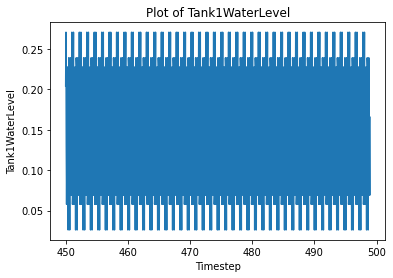

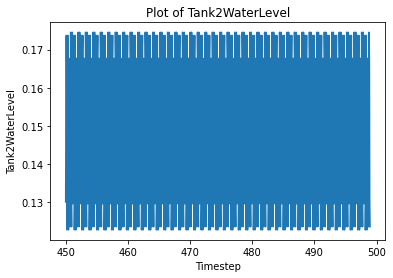

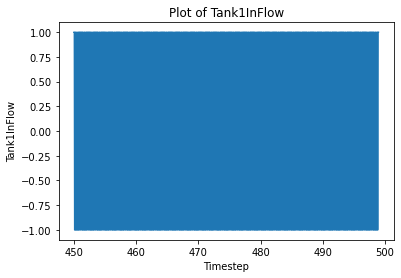

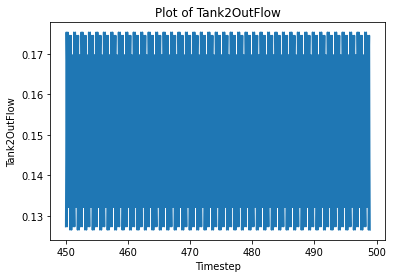

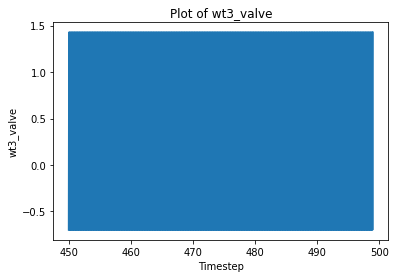

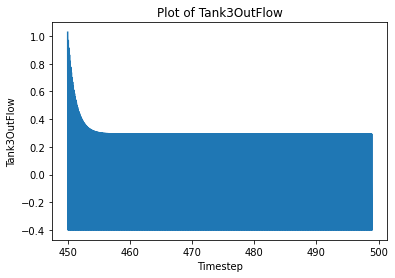

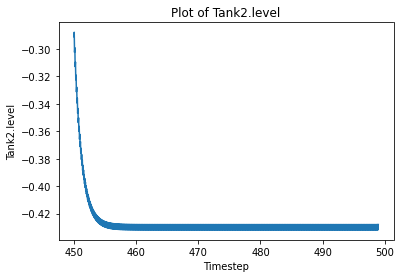

In [92]:
## SPecify the signal range
begin4 = 9000
finish4 = 9980
input4 = testData.iloc[begin4:finish4,:]

## Visualise the input signals
plot_series(input4,attr)

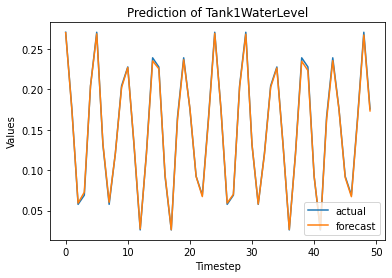

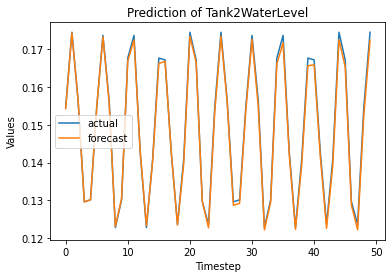

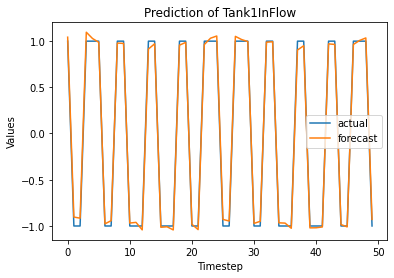

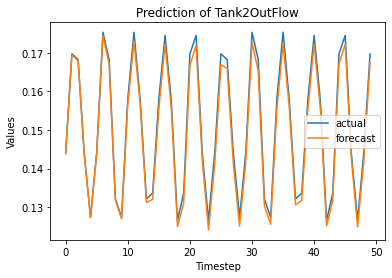

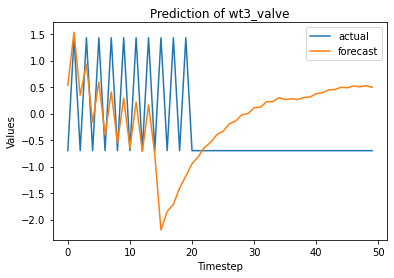

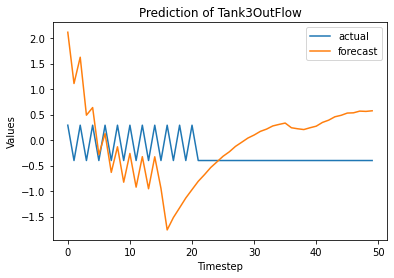

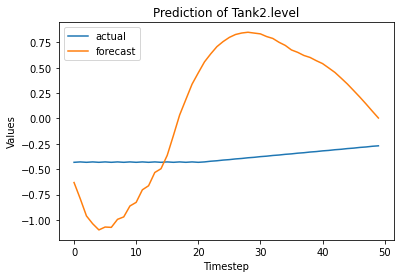

In [93]:
steps = 50
predictions4 = golden_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
predictions4_df = pd.DataFrame(predictions4, columns=input4.columns)

# plot_series(predictions_df, attr)
expected4 = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4, predictions4_df, attr)
# plot_multiple_series(actual, pred, attr)

In [94]:
expected4 = expected4.reset_index(drop=True)
RMSE4_golden = []
for feat in attr:
    RMSE4_golden.append(root_mse(predictions4_df[feat], expected4[feat]))
print(RMSE4_golden)

[0.0020422314326310254, 0.0010757745865334907, 0.04408838346287239, 0.0019843597155940087, 1.1438563855537027, 0.8168913981783377, 0.8052372009035776]


#### ValueFlip

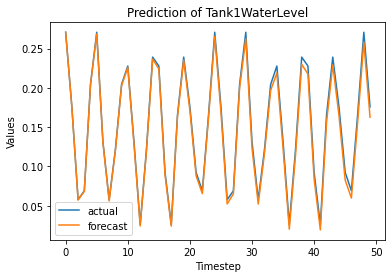

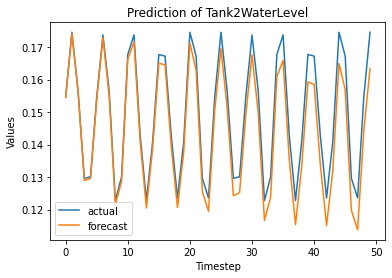

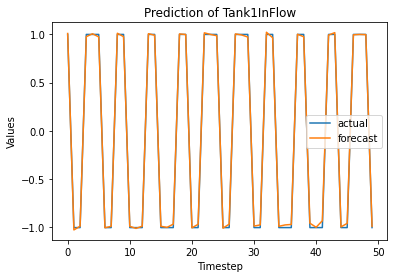

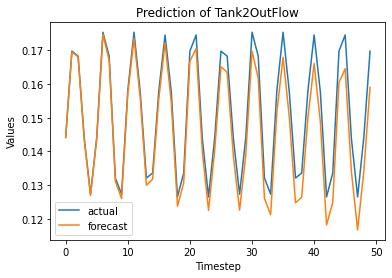

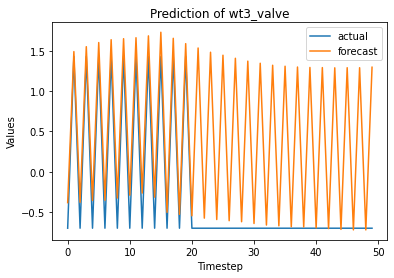

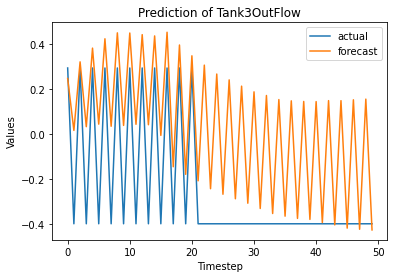

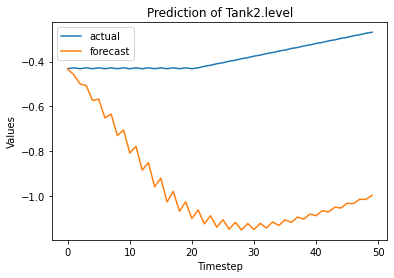

In [95]:
steps = 50
pred4_valueFlip = valueFlip_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
pred4_valueFlip_df = pd.DataFrame(pred4_valueFlip, columns=input4.columns)

# plot_series(predictions_df, attr)
expected4_valueFlip = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4_valueFlip, pred4_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [96]:
expected4_valueFlip = expected4_valueFlip.reset_index(drop=True)
RMSE4_vf = []
for feat in attr:
    RMSE4_vf.append(root_mse(pred4_valueFlip_df[feat], expected4_valueFlip[feat]))
print(RMSE4_vf)

[0.006258760091202072, 0.0058714236717422146, 0.021687183422587516, 0.0056663824150407025, 1.1387294026226993, 0.36471682248631815, 0.6211608421562931]


### Stuck at zero

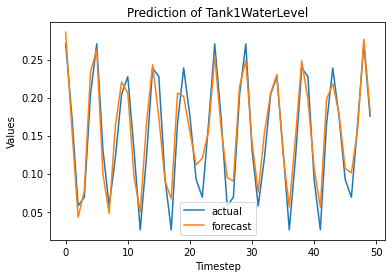

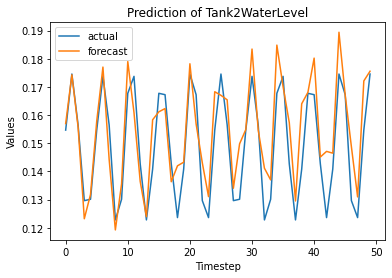

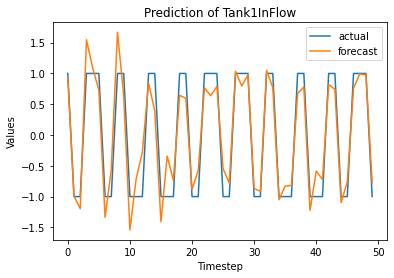

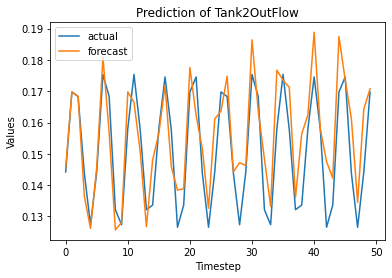

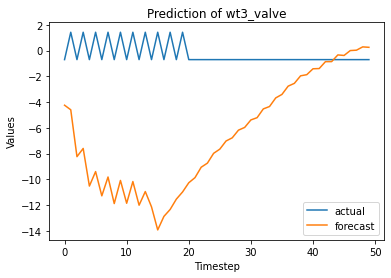

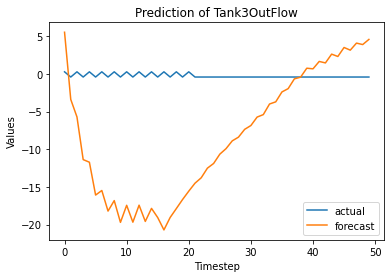

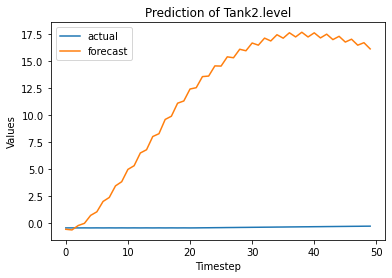

In [97]:
steps = 50
pred4_stuckat0 = stuckat0_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
pred4_stuckat0_df = pd.DataFrame(pred4_stuckat0, columns=input4.columns)

# plot_series(predictions_df, attr)
expected4_stuckat0 = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4_stuckat0, pred4_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [98]:
expected4_stuckat0 = expected4_stuckat0.reset_index(drop=True)
RMSE4_s0 = []
for feat in attr:
    RMSE4_s0.append(root_mse(pred4_stuckat0_df[feat], expected4_stuckat0[feat]))

print(RMSE4_s0)

[0.025009296054276334, 0.010708195805194835, 0.3207454811036641, 0.01047606322672032, 7.830503112233131, 11.645022476745492, 13.481904833478552]


### stuckat one

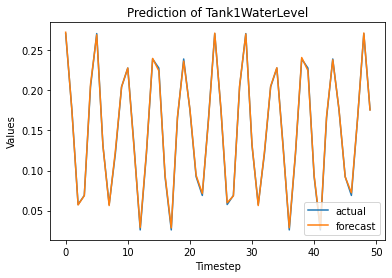

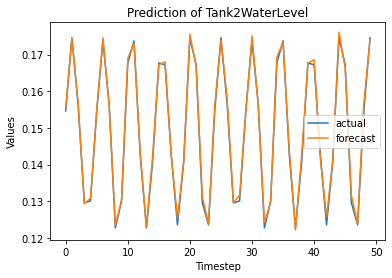

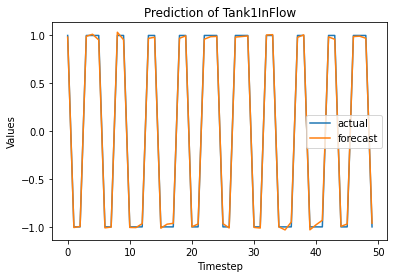

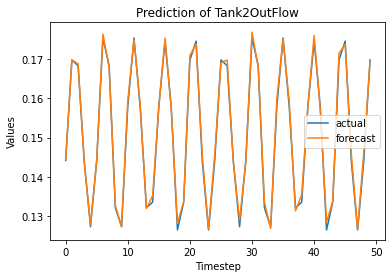

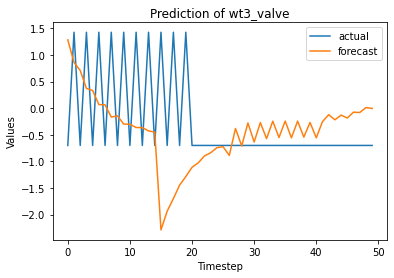

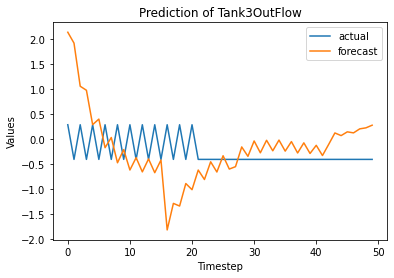

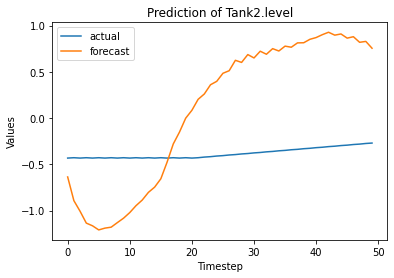

In [99]:
steps = 50
pred4_stuckat1 = stuckat1_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
pred4_stuckat1_df = pd.DataFrame(pred4_stuckat1, columns=input4.columns)
pred4_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected4_stuckat1 = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4_stuckat1, pred4_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [100]:
expected4_stuckat1 = expected4_stuckat1.reset_index(drop=True)
RMSE4_s1 = []
for feat in attr:
    RMSE4_s1.append(root_mse(pred4_stuckat1_df[feat], expected4_stuckat1[feat]))

print(RMSE4_s1)

[0.0017981578072716888, 0.0010395260418109952, 0.02520115088974159, 0.0010442077294275985, 1.1102680044471176, 0.7619985550165135, 0.878818573055144]


### End of the Notebook